In [1]:
using DifferentialEquations
using Plots
using LinearAlgebra
import ForwardDiff
import DiffResults
using AstrodynamicsBase
using Printf
using JSON
using CSV
using DataFrames
using ColorSchemes
using LaTeXStrings

In [2]:
include("../src/SailorMoon.jl")   # relative path to main file of module
param3b = SailorMoon.dynamics_parameters()
paramMulti = SailorMoon.multi_shoot_parameters(param3b)
gr()
fs = 16


┌ Warning: Replacing docs for `Main.SailorMoon.integrate_rk4 :: Union{Tuple{ODEProblem, Real}, Tuple{ODEProblem, Real, Union{Nothing, Vector{T} where T}}, Tuple{ODEProblem, Real, Union{Nothing, Vector{T} where T}, Bool}, Tuple{ODEProblem, Real, Union{Nothing, Vector{T} where T}, Bool, Bool}}` in module `Main.SailorMoon`
└ @ Base.Docs docs\Docs.jl:240


16

In [6]:
### PARAMETERS ###################################
# csv file to load the initial solution
filename = "../run/data/diffcorr_0619_NoThrust.csv"
# dv_dir function corresponding to the csv file 
dir_func = SailorMoon.dv_no_thrust

n_arc = 5

##################################################

if dir_func == SailorMoon.dv_no_thrust
    τ_ig = 0.0
else 
    τ_ig = 1.0
end

# load initial guess
df = CSV.read(filename, DataFrame; header=0);


In [7]:
p_ = plot(
    size=(700,500), 
    frame_style=:box, aspect_ratio=:equal, grid=0.4, 
    legend=false, 
    xlabel=L"t", ylabel=L"val",
    colorbar_titlefontsize=fs,
    fontsize=fs, xlabelfontsize=fs, ylabelfontsize=fs, xtickfontsize=fs-1, ytickfontsize=fs-1, legendfontsize=fs-1
);

In [14]:
row = df[1,:]
x = collect(row[4:end])
t_, u_  = SailorMoon.x2time_series(x, dir_func, paramMulti);

In [15]:
# compute JC from state in EMrot
function compute_JC(state::Vector)
    x, y, z = state[1], state[2], state[3]
    vx, vy, vz = state[4], state[5], state[6]
    r13 = norm([x-param3b.mu2, y, z])  # Earth - SC
    r23 = norm([x-param3b.mu1, y, z])  # Moon - SC
    
    U = 1/2*(x^2+y^2) + param3b.mu1 / r13 + param3b.mu2 / r23 
    JC = 2*U - (vx^2 + vy^2 + vz^2)
    
    return JC 
end

compute_JC (generic function with 1 method)

In [18]:
θlpo = x[19+12*paramMulti.n_arc]

u_emrots = []
JC_vec = []

for (i, tnow) in enumerate(t_)
    θm = θlpo - param3b.oml * tnow
    u_sb1   = u_[1:6,i]
    u_emrot = SailorMoon.transform_SunB1_to_EMrot(u_sb1, θm, param3b.oml, param3b.as)
    u_emrots = push!(u_emrots, transpose(u_emrot))
    
    jc = SailorMoon.compute_JC(u_emrot)
    push!(JC_vec, jc)
end
u_emrots = Array(reshape(hcat(u_emrots...), 6, size(u_emrots,1)));



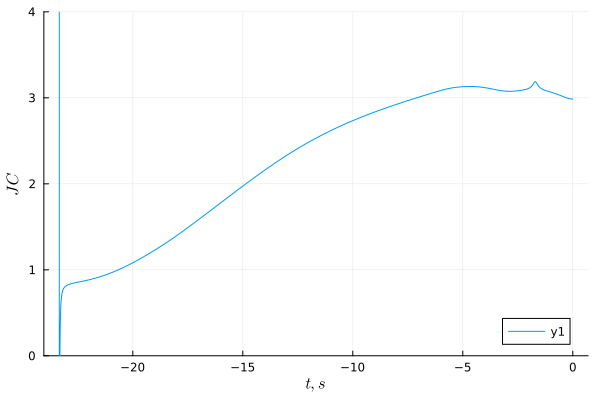

In [19]:
plot(t_, JC_vec, ylim=[0,4], xlabel=L"t,s", ylabel=L"JC")